# Document/Word Visualization using Embedding
1. MDS
2. LLE
3. ISOMAP
4. T-SNE

## document-term matrix
20160-10-24일의 뉴스에 대해 한글과 숫자만 남겨둔 파일을, corpus를 이용하여 읽어드림. term frequency matrix를 만들기 위함이기 때문에 iter_sent=False로 설정

In [1]:
corpus_fname = "/home/paulkim/workspace/python/Korean_NLP/data/corpus_10days/news/2016-10-24_article_all_normed.txt"

from corpus import Corpus
corpus = Corpus(corpus_fname, iter_sent = False)
len(corpus)

26368

이전의 명사 추출기를 이용하여 당일의 뉴스에 대한 명사 사전을 만들어두었었음. tmp폴더 에 존재함. 다른 corpus를 이용할 경우에는 그에 적합한 tokenizer를 만들어야 함

이런 작업은, 해당 코퍼스에 적합한 토크나이저가 존재하지 않을 때의 예시임. 뉴스 분석에 트위터분석기와 같이 공개괸 라이브러리가 적합하다면 이를 이용해도 괜찮음. Universial tokenizer를 미리 만든어둔 뒤, 이를 이용해도 좋음

In [2]:
import pickle

with open('extracted_noun_dict.pkl', 'rb') as f:
    noun_dict = pickle.load(f)
    
def custom_tokenize(doc):
    def parse_noun(token):
        for e in reversed(range(1, len(token) + 1)):
            subword = token[:e]
            if subword in noun_dict:
                return subword
        return ''
    
    nouns = [parse_noun(token) for token in doc.split()]
    nouns = [word for word in nouns if word]
    return nouns

CounterVectorizer는 doc-term-frequency matrix를 만듬. 문서는 단어의 빈도로 표현됨. 이때의 row id는 document id임

    doc = {term1 : f1, term3: f3, ...}
    
그런데, 이 행렬을 transpose하면 term-doc-frequency matrix가 됨. 이 때 row id는 term id가 됨. 그리고 각 term은 어떤 문서에서 몇 번 등장했는지, 그 빈도수로 표현됨

    term = {doc1: f1, ...}
    
즉, 각 단어들이 문서 갯수만큼의 공간 벡터로 표현됨. 만약 두 단어가 늘 함께 등장한다면, 문서 벡터가 매우 유사할 것임. 즉, 서로 함께 등장하는 단어를 문서 벡터로부터 유추할 수 있음(topic modeling)

물론 더 정교한 topic modeling은 이보다 더 정교한 수리적인 모델링에 기반함. 그 운리는 두 간어가 얼마나 같은 문서에서 등장하는지 그 경향성을 파악하는 것임

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
from scipy.io import mmwrite, mmread

vectorizer = CountVectorizer(tokenizer=custom_tokenize)
x = vectorizer.fit_transform(corpus)

In [4]:
x.shape

(26368, 4760)

In [5]:
index2word = [word for word, idx in sorted(vectorizer.vocabulary_.items(), key=lambda x:x[1])]
for word in index2word[:3]:
    print(word, vectorizer.vocabulary_[word])

00 0
000원 1
01 2


transpose()를 한 결과를 확인하면 행렬의 모양이 바뀐것을 확인할 수 있음

In [6]:
x = x.transpose()
print('term2doc matrix shape = %s, num_term = %d'%(str(x.shape), len(index2word)))

term2doc matrix shape = (4760, 26368), num_term = 4760


시각화를 위해 행렬을 dense matrix로 변환함

In [7]:
x_dense = x.todense()

sklearn.preprocessing의 normalize는 행렬을 정규화해줌

norm='l2'는 벡터의 크기가 1이 되도록 하는 것이고, norm='l1'으로 설정할 경우, 벡터의 값의 합이 1이 됨.

axis=0은 column의 norm이 1이 되도록 하는 것이고, axis=1은 row의 norm이 1이 되도록 하는 것임

In [8]:
from sklearn.preprocessing import normalize

x_dense = normalize(x_dense, axis = 1, norm='l2')

In [9]:
sum(x_dense[0] ** 2)

0.99999999999999034

# Import matplotlib
**각자의 OS에서 사용할 수 있는 폰트 확인**
matplotlib.font_manager를 이용하여 os에서 사용할 수 있는 폰트리스트를 확인

In [10]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

list(matplotlib.font_manager.get_fontconfig_fonts())[:5]

['/usr/share/fonts/truetype/font-awesome/fontawesome-webfont.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf',
 '/usr/share/fonts/opentype/font-awesome/FontAwesome.otf',
 '/usr/share/fonts/truetype/msttcorefonts/Verdana_Italic.ttf',
 '/usr/share/fonts/truetype/msttcorefonts/cour.ttf']

In [11]:
krfont = {'family' : 'nanumgothic', 'weight' : 'bold', 'size' : 10}
matplotlib.rc('font', **krfont)

# T-SNE
t-sne를 이용하여 문서 개수의 차원으로 표현된 단어 벡터를 2차원으로 시각화 함. sklearn의 manifold를 사용

모든 알고리즘들에서 n_components는 임베딩할 공간의 크기를 의미함

또한 임베딩 알고리즘들은 데이터의 갯수 (row의 갯수)가 커질수록 기하급수적으로 계산 시간이 커지는 경향이 존재함. 대부분의 알고리즘들이 O(N log N) 이상, 길게는 O(N^3)이기도 함.

그러므로, 시간이 오래 걸리는 작업은 데이터를 작게 만들어 먼저 경향성을 살펴본 뒤 돌리는 것이 좋음. (%%time)

sklearn에 구현되어 있는 t-SNE는 [origininal t-SNE][original_tsne]가 아닌, 2014년에 동일한 저자가 발표한 [approximated t-SNE][acce_tsne]임. 이 알고리즘은 O(N log N)의 비용으로 학습을 할 수 있지만, 그 마저도 데이터의 크기가 클 경우에는 매우 느림

현실적인 임베딩 방법 중 하나는, 중요한 데이터 포인트들을 샘플링하여 (예를 들어 빈도수가 높은, 혹은 키워드들) 먼저 임베딩을 시킨 뒤, 다른 데이터들을 가장 비슷한 몇 개의 점들의 임베딩 벡터의 평균 값으로 inferring하는 것임

landmark t-SNE라고 불리며, [original t-SNE][original_tsne]에서도 언급됨. 이 방법이 전체 데이터를 한 번에 임베딩하여 시각화 하는 것보다 좋은 이유도 있음. 빈도수가 작은 단어들은 몇 번 등장하지 않았기 때문에, 빈도수가 높은 단어들보다 좀 더 틀려도 됨. 반대로 자주 증당하는 단어들은 어떤 구조를 잡는데 훨씬 더 중요할 것임. 그러나 알고리즘은 이런 빈도수르르 고려하지 않고, 모든 단어간 거리의 중요도가 동일함. 그렇기 때문에 단어부터 먼저 임베딩 하는 것도 아주 좋은 방법임

[original_tsne]: http://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf
[acce_tsne]: http://www.jmlr.org/papers/volume15/vandermaaten14a/source/vandermaaten14a.pdf

In [12]:
%%time

from sklearn.manifold import TSNE

tsne = TSNE(n_components = 2)
y_tsne = tsne.fit_transform(x_dense)

y_tsne.shape

CPU times: user 22min 25s, sys: 5.87 s, total: 22min 31s
Wall time: 22min 33s


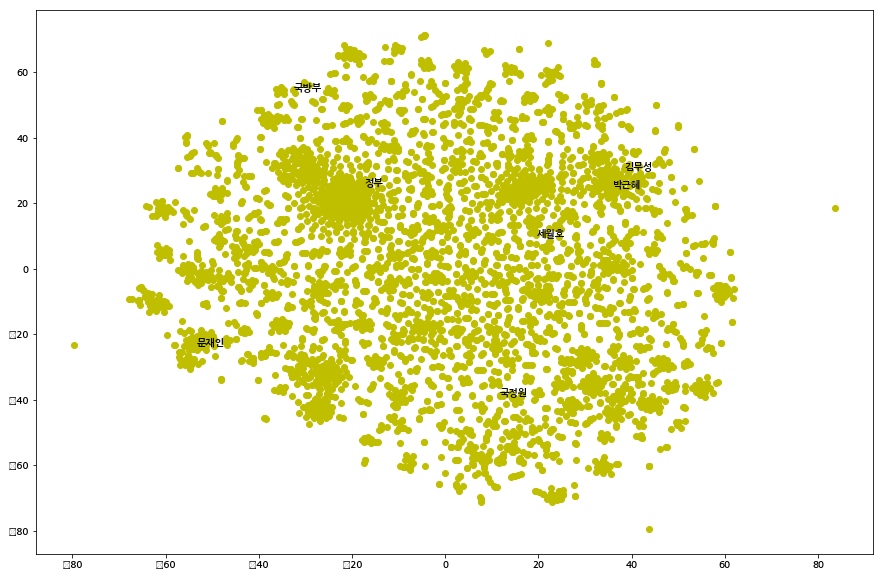

In [13]:
plt.figure(figsize=(15, 10))
plt.scatter(y_tsne[:, 0], y_tsne[:, 1], color = 'y')
for word in ['김무성', '박근혜', '문재인', '국방부', '정부', '국정원', '세월호']:
    idx = vectorizer.vocabulary_.get(word, -1)
    if idx == 1:
        continue
    plt.annotate(word, (y_tsne[idx, 0], y_tsne[idx, 1]))
    
plt.show()

## MDS

MDS로 동일한 작업을 수행함

T-SNE가 구형이긴 하지만, 울퉁불퉁한 모양을 하고 있다면, MDS는 구 형과 비슷한 모양을 보임

In [14]:
%%time

from sklearn.manifold import MDS

mds = MDS(n_components = 2)
y_mds = mds.fit_transform(x_dense)

y_mds.shape

CPU times: user 25min 12s, sys: 4min 29s, total: 29min 41s
Wall time: 11min 35s


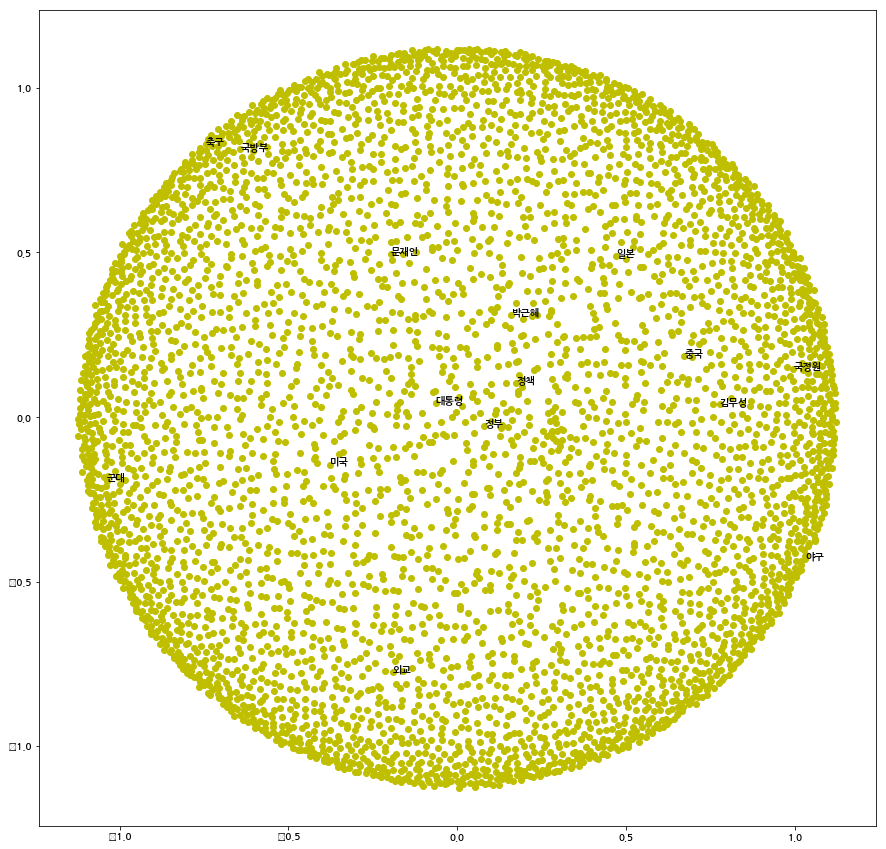

In [15]:
plt.figure(figsize=(15, 10))
plt.scatter(y_mds[:, 0], y_mds[:, 1], color = 'y')

for word in ['김무성', '박근혜', '문재인', '국방부', '정부', '국정원', '대통령', '축구', '야구', '외교', '정책', '군대', '미국', '일본', '중국']:
    idx = vectorizer.vocabulary_.get(word, -1)
    if idx == 1:
        continue
    plt.annotate(word, (y_mds[idx, 0], y_mds[idx, 1]))
    
plt.show()

## LLE

LLE와 ISOMAP은 k-NN 구조가 아주 뚜렷하게 잘 표현되는 데이터에 대해서는 그 모양이 잘 나옴(ex. swissroll data). 그러나 두 알고리즘 모두. 최인접이웃의 구조가 뚜렷하지 않을 경우 모양이 매우 민감하게 꼬이는 경향이 있음

특히 단어를 문서 벡터로 표현한 경우에는, 지나친 고차원이기 때문에 많은 단어들이 하나의 군집으로 묶이는 것처럼 보임. 이런 경우에는 모양이 좋지 않게 학습됨

경험적으로는 T-SNE보다 민감하게 학습모양이 바뀌는 경향이 있음

In [16]:
%%time

from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2)
y_lle = lle.fit_transform(x_dense)

y_lle.shape

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs


(4760, 2)

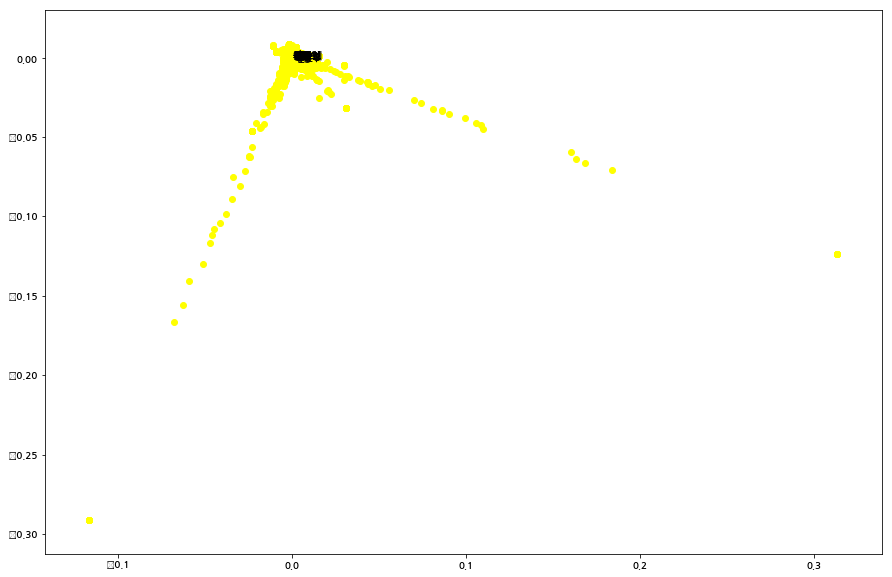

In [17]:
plt.figure(figsize=(15, 10))
plt.scatter(y_lle[:, 0], y_lle[:, 1], color = 'yellow')

for word in ['김무성', '박근혜', '문재인', '국방부', '정부', '국정원', '대통령', '축구', '야구', '외교', '정책', '군대', '미국', '일본', '중국']:
    idx = vectorizer.vocabulary_.get(word, -1)
    if idx == -1:
        continue
    plt.annotate(word, (y_lle[idx, 0], y_lle[idx, 1]))
    
plt.show()

## ISOMAP

In [18]:
%%time

from sklearn.manifold import Isomap

isomap = Isomap(n_components = 2)
y_isomap = isomap.fit_transform(x_dense)

y_isomap.shape

CPU times: user 20min 48s, sys: 828 ms, total: 20min 49s
Wall time: 20min 48s


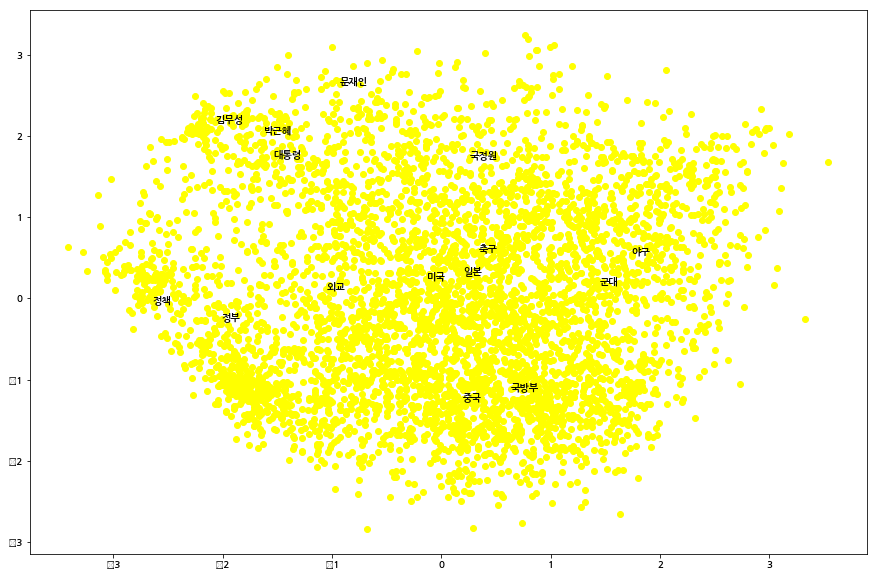

In [19]:
plt.figure(figsize=(15,10))
plt.scatter(y_isomap[:,0], y_isomap[:,1], color='yellow')

for word in ['김무성', '박근혜', '문재인', '국방부', '정부', '국정원', '대통령', '축구', '야구', '외교', '정책', '군대', '미국', '일본', '중국']:
    idx = vectorizer.vocabulary_.get(word, -1)
    if idx == -1:
        continue
    plt.annotate(word, (y_isomap[idx, 0], y_isomap[idx, 1]))

plt.show()